# Counter Current Heat Exchanger

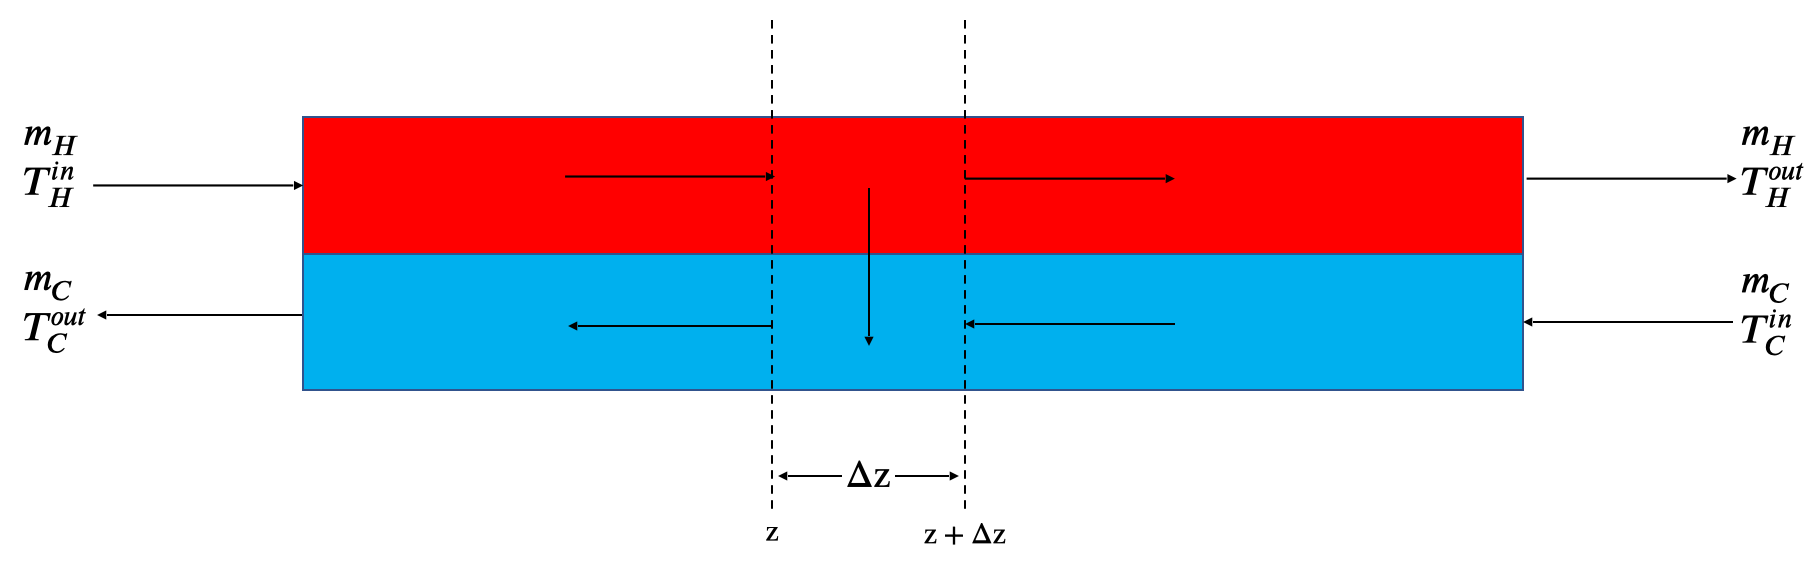

In [6]:
from IPython.display import Image
Image(filename = 'diagram.png', width = 700, height = 200)

For hot fluid : 
$$ 
\frac {dH_H}{dz} = \frac {-Up}{m_H}(T_H - T_C)  \  ; \  T_H(z = 0) = T^{in}_H
$$
For cold fluid :
$$
\frac {dH_C}{dz} = \frac {-Up}{m_C}(T_H - T_C)  \  ; \  T_C(z = L) = T^{in}_C
$$

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate 
import pandas as pd
from matplotlib import style
style.use("classic")

In [151]:
df = pd.read_excel('Cp_data.xlsx').replace(np.NaN,0)

In [152]:
df

,Name,CAS no.,Mol. wt.,C1,C2,C3,C4,C5,"Tmin, K","Tmax, K"
0,Acetaldehyde,75-07-0,44.053,115100.0,-433.0000,1.42500,0.000000,0.000000,150.15,294.00
1,Acetamide,60-35-5,59.067,102300.0,128.7000,0.00000,0.000000,0.000000,354.15,571.00
2,Acetic acid,64-19-7,60.052,139640.0,-320.8000,0.89850,0.000000,0.000000,289.81,391.05
3,Acetic anhydride,108-24-7,102.089,36600.0,511.0000,0.00000,0.000000,0.000000,250.00,350.00
4,Acetone,67-64-1,58.079,135600.0,-177.0000,0.28370,0.000689,0.000000,178.45,329.44
...,...,...,...,...,...,...,...,...,...,...
232,Water,7732-18-5,18.015,276370.0,-2090.1000,8.12500,-0.014116,0.000009,273.16,533.15
233,p-Xylene,106-42-3,106.165,-35500.0,1287.2000,-2.59900,0.002426,0.000000,286.41,600.00
234,m-Xylene,108-38-3,106.165,133860.0,7.8754,0.52265,0.000000,0.000000,217.00,540.15
235,o-Xylene,95-47-6,106.165,36500.0,1017.5000,-2.63000,0.003020,0.000000,247.98,417.58


In [153]:
comp = df['Name']
c1 = df['C1']
c2 = df['C2']
c3 = df['C3']
c4 = df['C4']
c5 = df['C5']
MW = df['Mol. wt.']

In [154]:
hot_C = 'Water'  # hot fluid
col_C = 'Ethylene glycol'   # cold fluid

In [155]:
hi = comp.index[comp == hot_C][0]
ci = comp.index[comp == col_C][0]
Tref = 298.15 #K

In [156]:
def H_H(T): #T in K
    H = (c1[hi]*(T - Tref) + c2[hi]*(T**2 - Tref**2)/2 + c3[hi] * (T ** 3 - Tref ** 3) / 3 + c4[hi] * (T ** 4 - Tref ** 4) / 4 +
           c5[hi] * (T ** 5 - Tref ** 5) / 5) / MW[hi]

    return H
    
def H_C(T): # T in K
    H = (c1[ci]*(T - Tref) + c2[ci]*(T**2 - Tref**2)/2 + c3[ci] * (T ** 3 - Tref ** 3) / 3 + c4[ci] * (T ** 4 - Tref ** 4) / 4 +
           c5[ci] * (T ** 5 - Tref ** 5) / 5) / MW[ci]

    return H

Text(0.5, 1.0, 'Hot fluid: Water & Cold fluid: Ethylene glycol')

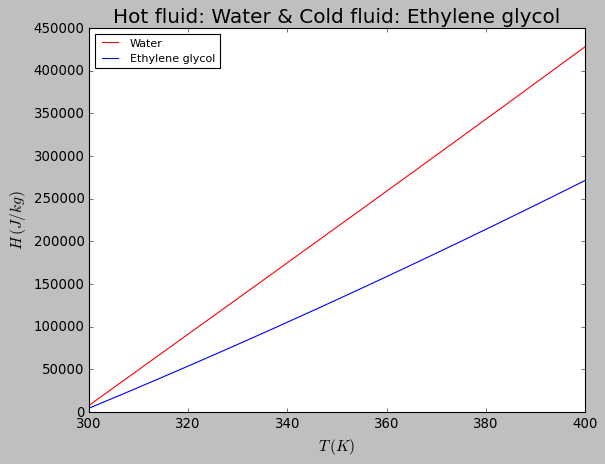

In [164]:
T = np.linspace(300, 400, 500)
plt.plot(T, H_H(T), 'r',label = hot_C)
plt.plot(T, H_C(T), 'b',label = col_C)
plt.legend(loc= 'best',fontsize = 10)
plt.xlabel(r'$T\, (K)$',fontsize = 14)
plt.ylabel(r'$H\, (J/kg)$',fontsize = 14)
plt.title("Hot fluid: %s & Cold fluid: %s" % (hot_C, col_C),fontsize = 18)

In [158]:
import scipy.interpolate
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

In [159]:
T_H(1e5)

array(322.08253773)

In [160]:
def model(SV, z, heatx):
    [H_H, H_C] = SV
    
    U = heatx.U
    P = heatx.P
    mH = heatx.mH
    mC = heatx.mC
    
    T_H = heatx.T_H(H_H)
    T_C = heatx.T_C(H_C)
    
    dH_Hbydz = -U*P/mH * (T_H - T_C)
    dH_Cbydz = -U*P/mC * (T_H - T_C)
    
    return [dH_Hbydz, dH_Cbydz]

In [161]:
def shoot(T_Cout, heatx):
    heatx.T_Cout = T_Cout

    SV0 = [H_H(heatx.T_Hin), H_C(heatx.T_Cout)]
    z = [0, heatx.L]
    solution = scipy.integrate.odeint(
                                        model,
                                        SV0,
                                        z,
                                        args = (heatx,)
    )
    H_Cin = solution[-1, 1]
    T_Cin = heatx.T_C(H_Cin)

    error = [T_Cin - heatx.T_Cin]
    return error


class HeatX:
    def __init__(self):
        self.U = 400.0 #W/m2-K
        self.P = 0.1 #m2/m
        self.L = 1.0 #m
        
        self.mH = 0.01 #kg/s
        self.mC = 0.01 #kg/s
        self.T_Hin = 373.16 #K
        self.T_Cin = 303.16 #K
    
    def initialize(self):
        T = np.linspace(self.T_Cin, self.T_Hin, 1000)
        self.T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)
    
    def solve(self, n = 100):
        
        self.initialize()
        
        guess = [self.T_Cin + 0.0]
        
        lsq = scipy.optimize.least_squares(shoot, guess, args = (self,))
        
        SV0 = [H_H(self.T_Hin), H_C(self.T_Cout)]
        z = np.linspace(0,self.L, n)
        solution = scipy.integrate.odeint(
                                        model,
                                        SV0,
                                        z,
                                        args = (self,)
        )
        H_Hsol = solution[:,0]
        H_Csol = solution[:,1]
        
        self.solutiondf = pd.DataFrame({
                                    "z":z,
                                    "T_H":self.T_H(H_Hsol),
                                    "T_C":self.T_C(H_Csol)
        })
        
        
        
        
        


In [162]:
heatx = HeatX()


Text(0.5, 1.0, 'Hot fluid: Water & Cold fluid: Ethylene glycol')

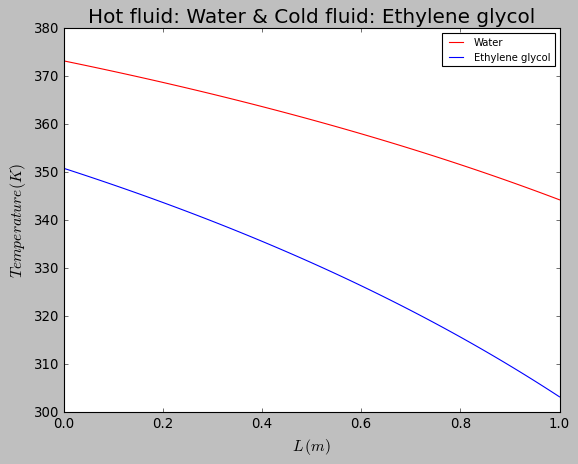

In [163]:
heatx.solve()
plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_H, 'r',label = hot_C)
plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_C, 'b',label = col_C)
plt.legend(fontsize = 9,loc = 'best')
plt.xlabel('$L\, (m) $',fontsize = 14)
plt.ylabel('$ Temperature (K)$',fontsize  = 14)
plt.title("Hot fluid: %s & Cold fluid: %s" % (hot_C, col_C),fontsize = 18)